# **Preprocesamiento de datos**

Se creará un DataFrame con los [8 pilares](https://docs.google.com/document/d/1NbQ_QN8_AUV5ZjQiJfj12etHY2h-ymiX1Crkkpu_nGg/edit) para las acciones del S&P500

# 1. Carga de datos

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
df_stocks = pd.read_csv('/gdrive/Shareddrives/Proyecto Minería de Datos/Datos/sp500_companies.csv')
df_stocks = df_stocks.sort_values('Symbol')
df_stocks = df_stocks.set_index('Symbol')

In [4]:
df_stocks.dtypes

Exchange                object
Shortname               object
Longname                object
Sector                  object
Industry                object
Currentprice           float64
Marketcap                int64
Ebitda                 float64
Revenuegrowth          float64
City                    object
State                   object
Country                 object
Fulltimeemployees      float64
Longbusinesssummary     object
Weight                 float64
dtype: object

In [5]:
df_fundamentals = pd.read_csv("/gdrive/Shareddrives/Proyecto Minería de Datos/Datos/5yr_fundamentals_S&P500.txt", on_bad_lines='skip', header = 0, encoding='windows-1252', sep=";").drop_duplicates()
df_fundamentals = df_fundamentals.sort_values('ticker')

In [6]:
df_fundamentals.dtypes

ticker          object
year             int64
marketcap      float64
net_income     float64
revenue        float64
fcf            float64
ltl            float64
so             float64
debt_equity    float64
dtype: object

Creamos una base con los fundamentos del 2021 y otra con los del 2017. Posteriormente serán requeridas.

In [7]:
fundamentals_2021 = df_fundamentals[df_fundamentals['year'] == 2021]
fundamentals_2017 = df_fundamentals[df_fundamentals['year'] == 2017]

Nos aseguramos de que las 3 bases tengan las mismas acciones

In [8]:
list_not_in = list(set(df_fundamentals['ticker']) - set(fundamentals_2021['ticker']))
print(list_not_in)
list_not_in = list_not_in + list(set(df_fundamentals['ticker']) - set(fundamentals_2017['ticker']))
print(list_not_in)
list_not_in = list_not_in + list(set(df_fundamentals['ticker']) - set(df_stocks.index))
print(list_not_in)
list_not_in = list_not_in + list(set(df_stocks.index) - set(df_fundamentals['ticker']))
print(list_not_in)

['BF-B', 'KR', 'LUMN']
['BF-B', 'KR', 'LUMN', 'FOXA', 'DOW', 'OTIS', 'CTVA', 'MRNA', 'OGN', 'CEG', 'FOX', 'CDAY', 'CARR']
['BF-B', 'KR', 'LUMN', 'FOXA', 'DOW', 'OTIS', 'CTVA', 'MRNA', 'OGN', 'CEG', 'FOX', 'CDAY', 'CARR', 'TWTR', 'NLSN', 'ELV', 'CEG']
['BF-B', 'KR', 'LUMN', 'FOXA', 'DOW', 'OTIS', 'CTVA', 'MRNA', 'OGN', 'CEG', 'FOX', 'CDAY', 'CARR', 'TWTR', 'NLSN', 'ELV', 'CEG', 'TRGP', 'ACGL']


Ahora procedemos a eliminar estas dos acciones de df_fundamentals

In [9]:
for i in list_not_in:
  df_fundamentals.drop(df_fundamentals[df_fundamentals['ticker'] == i].index, inplace = True)
  df_stocks.drop(df_stocks[df_stocks.index == i].index, inplace = True)
  fundamentals_2021.drop(fundamentals_2021[fundamentals_2021['ticker'] == i].index, inplace = True)
  fundamentals_2017.drop(fundamentals_2017[fundamentals_2017['ticker'] == i].index, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
df_fundamentals

,ticker,year,marketcap,net_income,revenue,fcf,ltl,so,debt_equity
917,A,2018,2.322435e+10,3.160000e+08,4.914000e+09,9.100000e+08,2.799000e+09,321000000.0,6.370000e+09
914,A,2021,4.587360e+10,1.210000e+09,6.319000e+09,1.296000e+09,3.608000e+09,304000000.0,8.118000e+09
918,A,2017,2.229528e+10,6.840000e+08,4.472000e+09,7.130000e+08,2.328000e+09,322000000.0,6.846000e+09
916,A,2019,2.536178e+10,1.071000e+09,5.163000e+09,8.650000e+08,2.624000e+09,314000000.0,7.155000e+09
915,A,2020,3.612210e+10,7.190000e+08,5.339000e+09,8.020000e+08,3.287000e+09,309000000.0,7.232000e+09
...,...,...,...,...,...,...,...,...,...
487,ZTS,2018,4.110383e+10,1.428000e+09,5.825000e+09,1.452000e+09,7.369000e+09,483063000.0,8.637000e+09
484,ZTS,2021,9.286554e+10,2.037000e+09,7.776000e+09,1.736000e+09,7.559000e+09,475502000.0,1.128700e+10
488,ZTS,2017,3.838507e+10,8.640000e+08,5.307000e+09,1.122000e+09,5.706000e+09,489918000.0,6.739000e+09
486,ZTS,2019,6.599214e+10,1.500000e+09,6.260000e+09,1.335000e+09,7.031000e+09,478100000.0,9.319000e+09


In [28]:
df_stocks

,Exchange,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
Symbol,,,,,,,,,,,,,,,
A,NYQ,"Agilent Technologies, Inc.","Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,136.08,40285257728,1.922000e+09,0.083,Santa Clara,CA,United States,17700.0,"Agilent Technologies, Inc. provides applicatio...",0.001203
AAL,NMS,"American Airlines Group, Inc.",American Airlines Group Inc.,Industrials,Airlines,14.11,9170102272,2.400000e+09,0.501,Fort Worth,TX,United States,129700.0,"American Airlines Group Inc., through its subs...",0.000274
AAP,NYQ,Advance Auto Parts Inc.,"Advance Auto Parts, Inc.",Consumer Cyclical,Specialty Retail,181.07,10885603328,1.059585e+09,0.006,Raleigh,NC,United States,41000.0,"Advance Auto Parts, Inc. provides automotive r...",0.000325
AAPL,NMS,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,138.38,2201362890752,1.305410e+11,0.081,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.065735
ABBV,NYQ,AbbVie Inc.,AbbVie Inc.,Healthcare,Drug Manufacturers—General,145.28,256869564416,3.021200e+10,0.033,North Chicago,IL,United States,50000.0,"AbbVie Inc. discovers, develops, manufactures,...",0.007670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,NYQ,"Yum! Brands, Inc.","Yum! Brands, Inc.",Consumer Cyclical,Restaurants,121.78,35697733632,2.258000e+09,0.041,Louisville,KY,United States,36000.0,"YUM! Brands, Inc., together with its subsidiar...",0.001066
ZBH,NYQ,"Zimmer Biomet Holdings, Inc.","Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices,104.85,21904003072,2.366200e+09,0.039,Warsaw,IN,United States,19500.0,"Zimmer Biomet Holdings, Inc., together with it...",0.000654
ZBRA,NMS,Zebra Technologies Corporation,Zebra Technologies Corporation,Technology,Communication Equipment,230.56,12321472512,1.149000e+09,0.063,Lincolnshire,IL,United States,9800.0,"Zebra Technologies Corporation, together with ...",0.000368


In [29]:
pd.value_counts(df_stocks['Sector'])

Industrials               70
Technology                70
Financial Services        67
Healthcare                62
Consumer Cyclical         57
Consumer Defensive        34
Real Estate               32
Utilities                 29
Energy                    22
Basic Materials           19
Communication Services    19
Name: Sector, dtype: int64

In [31]:
pd.value_counts(df_stocks['Sector']) / len(df_stocks['Sector'])

Industrials               0.145530
Technology                0.145530
Financial Services        0.139293
Healthcare                0.128898
Consumer Cyclical         0.118503
Consumer Defensive        0.070686
Real Estate               0.066528
Utilities                 0.060291
Energy                    0.045738
Basic Materials           0.039501
Communication Services    0.039501
Name: Sector, dtype: float64

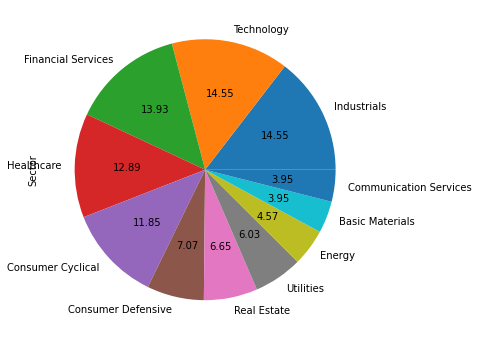

In [33]:
plot = df_stocks['Sector'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6))

In [12]:
fundamentals_2021

,ticker,year,marketcap,net_income,revenue,fcf,ltl,so,debt_equity
914,A,2021,4.587360e+10,1.210000e+09,6.319000e+09,1.296000e+09,3.608000e+09,3.040000e+08,8.118000e+09
2336,AAL,2021,1.007239e+10,-1.993000e+09,2.988200e+10,2.920000e+08,5.480100e+10,6.440150e+08,3.883700e+10
2188,AAP,2021,1.037889e+10,4.930210e+08,1.010632e+10,7.018820e+08,3.536209e+09,6.874800e+07,6.606995e+09
0,AAPL,2021,2.482477e+12,9.468000e+10,3.658170e+11,9.295300e+10,1.624310e+11,1.670127e+10,1.878090e+11
89,ABBV,2021,2.438891e+11,1.154200e+10,5.619700e+10,2.199000e+10,9.589900e+10,1.768338e+09,9.212000e+10
...,...,...,...,...,...,...,...,...,...
1073,YUM,2021,3.691648e+10,1.575000e+09,6.584000e+09,1.476000e+09,1.292400e+10,3.020000e+08,2.961000e+09
1378,ZBH,2021,2.429537e+10,4.016000e+08,7.836200e+09,1.327200e+09,7.322100e+09,2.070000e+08,1.973520e+10
1866,ZBRA,2021,2.632362e+10,8.370000e+08,5.627000e+09,1.010000e+09,1.431000e+09,5.344138e+07,4.129000e+09
2341,ZION,2021,1.115868e+10,1.129000e+09,2.923000e+09,4.230000e+08,1.012000e+09,1.637370e+08,8.475000e+09


In [13]:
fundamentals_2017

,ticker,year,marketcap,net_income,revenue,fcf,ltl,so,debt_equity
918,A,2017,2.229528e+10,6.840000e+08,4.472000e+09,7.130000e+08,2.328000e+09,3.220000e+08,6.846000e+09
2340,AAL,2017,2.572513e+10,1.919000e+09,4.220700e+10,-1.227000e+09,3.250600e+10,4.891640e+08,2.899100e+10
2191,AAP,2017,9.074935e+09,4.755050e+08,9.373784e+09,4.110470e+08,1.587008e+09,7.384600e+07,4.459523e+09
4,AAPL,2017,8.698186e+11,4.835100e+10,2.292340e+11,5.080300e+10,1.404580e+11,2.086897e+10,2.497270e+11
93,ABBV,2017,1.844961e+11,5.309000e+09,2.821600e+10,9.431000e+09,4.904800e+10,1.592131e+09,4.246500e+10
...,...,...,...,...,...,...,...,...,...
1077,YUM,2017,2.935273e+10,1.340000e+09,5.878000e+09,7.120000e+08,1.013300e+10,3.470000e+08,3.470000e+09
1382,ZBH,2017,2.468669e+10,1.813800e+09,7.824100e+09,1.426300e+09,1.120880e+10,2.019000e+08,2.185490e+10
1870,ZBRA,2017,6.581591e+09,1.700000e+07,3.722000e+09,4.280000e+08,2.441000e+09,5.302176e+07,3.061000e+09
2345,ZION,2017,1.082785e+10,5.920000e+08,2.609000e+09,7.590000e+08,3.830000e+08,2.007760e+08,1.166200e+10


# 2. Calculo 8 pilares

In [14]:
sum_fundamentals = df_fundamentals.groupby(['ticker']).sum()
sum_fundamentals

,year,marketcap,net_income,revenue,fcf,ltl,so,debt_equity
ticker,,,,,,,,
A,10095,1.528771e+11,4.000000e+09,2.620700e+10,4.586000e+09,1.464600e+10,1.570000e+09,3.572100e+10
AAL,10095,7.326624e+10,-5.861000e+09,1.797350e+11,-1.010100e+10,2.240680e+11,2.524666e+09,1.691680e+11
AAP,8075,4.072638e+10,1.879269e+09,3.876966e+10,2.125503e+09,9.948844e+09,2.871910e+08,1.995945e+10
AAPL,10095,7.550458e+12,3.152290e+11,1.395335e+12,3.401380e+11,7.400680e+11,9.321520e+10,1.035476e+12
ABBV,10095,8.471373e+11,3.503600e+10,1.962360e+11,7.377200e+10,3.860150e+11,8.083337e+09,3.241580e+11
...,...,...,...,...,...,...,...,...
YUM,10095,1.596297e+11,6.655000e+09,2.939900e+10,5.394000e+09,5.758600e+10,1.579000e+09,1.405100e+10
ZBH,10095,1.313979e+11,2.828900e+09,3.859990e+10,6.605900e+09,4.742610e+10,1.024500e+09,1.027209e+11
ZBRA,10095,7.610894e+10,2.323000e+09,2.250000e+10,3.678000e+09,8.423000e+09,2.674581e+08,1.668000e+10


Pilar 1:

In [15]:
pilar_1 = pd.DataFrame(data={'pilar_1':df_stocks['Marketcap']/sum_fundamentals['net_income']})
pilar_1.head()


,pilar_1
Symbol,
A,10.071314
AAL,-1.564597
AAP,5.792467
AAPL,6.983377
ABBV,7.331589


Pilar 2:

In [16]:
fundamentals_2021 = fundamentals_2021.set_index('ticker')

In [17]:
pilar_2 = pd.DataFrame(data={'pilar_2':sum_fundamentals['fcf']/fundamentals_2021['debt_equity']})
pilar_2.head()

,pilar_2
ticker,
A,0.564917
AAL,-0.260087
AAP,0.321705
AAPL,1.811085
ABBV,0.800825


Pilar 3:

In [18]:
fundamentals_2017 = fundamentals_2017.set_index('ticker')

In [19]:
pilar_3 = pd.DataFrame(data={'pilar_3':(fundamentals_2021['revenue']-fundamentals_2017['revenue'])/fundamentals_2017['revenue']})
pilar_3.head()

,pilar_3
ticker,
A,0.413014
AAL,-0.292013
AAP,0.078147
AAPL,0.595823
ABBV,0.991671


Pilar 4:

In [20]:
pilar_4 = pd.DataFrame(data={'pilar_4':(fundamentals_2021['net_income']-fundamentals_2017['net_income'])/fundamentals_2017['net_income']})
pilar_4.head()

,pilar_4
ticker,
A,0.769006
AAL,-2.038562
AAP,0.036837
AAPL,0.958181
ABBV,1.174044


Pilar 5:

In [21]:
pilar_5 = pd.DataFrame(data={'pilar_5':(fundamentals_2021['so']-fundamentals_2017['so'])/fundamentals_2017['so']})
pilar_5.head()

,pilar_5
ticker,
A,-0.055901
AAL,0.316563
AAP,-0.069036
AAPL,-0.199708
ABBV,0.110673


Pilar 6:

In [22]:
pilar_6 = pd.DataFrame(data={'pilar_6':fundamentals_2021['ltl']/sum_fundamentals['fcf']})
pilar_6.head()

,pilar_6
ticker,
A,0.786742
AAL,-5.425304
AAP,1.663705
AAPL,0.477544
ABBV,1.299938


Pilar 7:

In [23]:
pilar_7 = pd.DataFrame(data={'pilar_7':(fundamentals_2021['fcf']-fundamentals_2017['fcf'])/fundamentals_2017['fcf']})
pilar_7.head()

,pilar_7
ticker,
A,0.817672
AAL,-1.237979
AAP,0.707547
AAPL,0.829675
ABBV,1.331672


Pilar 8:

In [24]:
pilar_8 = pd.DataFrame(data={'pilar_8':df_stocks['Marketcap']/sum_fundamentals['fcf']})
pilar_8.head()

,pilar_8
Symbol,
A,8.784400
AAL,-0.907841
AAP,5.121425
AAPL,6.471970
ABBV,3.481938


# 3. Exportación de datos

Primero unimos los pilares en un gran DataFrame:

In [25]:
pilares = pd.concat([pilar_1, pilar_2, pilar_3, pilar_4, pilar_5, pilar_6, pilar_7, pilar_8], axis='columns')
pilares

,pilar_1,pilar_2,pilar_3,pilar_4,pilar_5,pilar_6,pilar_7,pilar_8
A,10.071314,0.564917,0.413014,0.769006,-0.055901,0.786742,0.817672,8.784400
AAL,-1.564597,-0.260087,-0.292013,-2.038562,0.316563,-5.425304,-1.237979,-0.907841
AAP,5.792467,0.321705,0.078147,0.036837,-0.069036,1.663705,0.707547,5.121425
AAPL,6.983377,1.811085,0.595823,0.958181,-0.199708,0.477544,0.829675,6.471970
ABBV,7.331589,0.800825,0.991671,1.174044,0.110673,1.299938,1.331672,3.481938
...,...,...,...,...,...,...,...,...
YUM,5.364047,1.821682,0.120109,0.175373,-0.129683,2.395996,1.073034,6.618045
ZBH,7.742940,0.334727,0.001547,-0.778586,0.025260,1.108418,-0.069480,3.315824
ZBRA,5.304121,0.890773,0.511822,48.235294,0.007914,0.389070,1.359813,3.350047
ZION,1.966060,0.396106,0.120353,0.907095,-0.184479,0.301460,-0.442688,2.319213


Ahora exportamos los datos:

In [26]:
pilares.to_csv(f'/gdrive/Shareddrives/Proyecto Minería de Datos/Entrega 2/Preprocesamiento de datos/DF_pilares.txt', index=True, sep=";")

#4. K-Means (No se usa esta parte alfinal. Se clusteriza en la carpeta clustering)

In [27]:
pca = PCA(n_components = 2)
components_pca = pca.fit_transform(pilares)

In [ ]:
df_pca = pd.DataFrame(data=components_pca)

In [ ]:
df_pca = df_pca[(df_pca[0] > -200) & (df_pca[0] < 200) & (df_pca[1] < 200)]

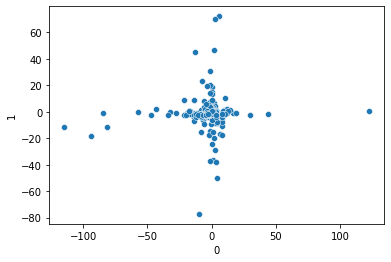

In [ ]:
sns.scatterplot(data=df_pca, x=0, y=1)

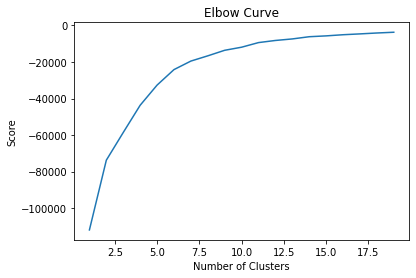

In [ ]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(df_pca).score(df_pca) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6).fit(df_pca)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 5.08879719e-01 -1.26054013e+00  4.71844785e-16]
 [-8.65026226e+01 -8.52987962e+00  1.00000000e+00]
 [ 1.22483878e+02  4.77682906e-01  4.00000000e+00]
 [ 5.99501204e-02 -4.16990178e+01  2.00000000e+00]
 [-7.66239072e-01  5.30782098e+01  3.00000000e+00]
 [-1.52432114e+01 -7.88235850e-01  4.54545455e-02]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
labels = kmeans.predict(df_pca)
# Getting the cluster centers
df_pca = df_pca.assign(Cluster=labels)
df_pca

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,0,1,Cluster
0,-4.689619,-1.592126,0
1,6.987461,-1.884719,0
2,-0.366843,-1.439345,0
3,-1.586299,-1.296165,0
4,-1.903524,-0.611227,0
...,...,...,...
476,0.052572,-1.310044,0
477,-2.299818,-1.990194,0
478,-0.011906,0.353074,0
479,3.474412,-2.095521,0


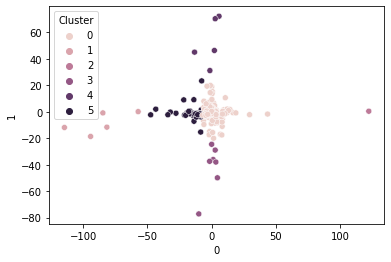

In [ ]:
sns.scatterplot(data=df_pca, x=0, y=1, hue="Cluster")